# 🇺🇦 Ukrainian OCR Pipeline - Local Testing Demo

High-performance OCR pipeline for historical Ukrainian documents with Named Entity Recognition (NER).

**Features:**
- ⚡ GPU-accelerated TrOCR for Cyrillic handwriting (or CPU fallback)
- 🎯 Named Entity Recognition for persons and locations
- 📋 ALTO XML output for archival standards
- 🎨 Person-dense region extraction
- 📊 Progress tracking and performance monitoring

**Local Environment Requirements:**
- Python 3.8+
- PyTorch (CPU or GPU)
- Ukrainian OCR package installed

## 🚀 Setup and Installation

First, let's install the Ukrainian OCR pipeline package and check system availability.

In [1]:
# Check if we're in the package directory and install
import os
import sys

# Add package to Python path if we're in development mode
if os.path.exists('../ukrainian_ocr'):
    sys.path.insert(0, '..')
    print("✅ Using development version from parent directory")
elif os.path.exists('./ukrainian_ocr'):
    sys.path.insert(0, '.')
    print("✅ Using development version from current directory")
else:
    print("📦 Using installed package")

# Test import
try:
    import ukrainian_ocr
    print(f"✅ Ukrainian OCR v{ukrainian_ocr.__version__} loaded successfully!")
except ImportError as e:
    print(f"❌ Error importing package: {e}")
    print("💡 Install with: pip install -e . (from package root)")

✅ Using development version from parent directory


/home/maria/ssd990/projects/tarkovsky/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Ukrainian OCR v1.0.0 loaded successfully!


In [2]:
# Check system capabilities
import torch
from ukrainian_ocr.utils.gpu import check_gpu_availability, optimize_for_device

print("🔍 System Information:")
print(f"  Python: {sys.version.split()[0]}")
print(f"  PyTorch: {torch.__version__}")
print(f"  CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
    print(f"  GPU Memory: {gpu_memory:.1f}GB")
    recommended_device = 'cuda'
else:
    print("  Will use CPU processing (slower but works)")
    recommended_device = 'cpu'

print(f"  Recommended device: {recommended_device}")

🔍 System Information:
  Python: 3.12.2
  PyTorch: 2.7.1+cu126
  CUDA available: False
  Will use CPU processing (slower but works)
  Recommended device: cpu


## 📁 Setup Test Images

Set up test images from your local filesystem.

In [3]:
# Define test image paths - modify these for your local setup
import glob
from pathlib import Path

# Option 1: Use specific test images
test_images = [
    "/home/maria/ssd990/projects/tarkovsky/Н-2982_4_1001/804-03494422-l-m-a-n2982-4-1001-00001.jpg",
    "/home/maria/ssd990/projects/tarkovsky/Н-2982_4_1001/804-03494422-l-m-a-n2982-4-1001-00002.jpg"
]

# Option 2: Auto-discover images in a directory
test_dir = "/home/maria/ssd990/projects/tarkovsky/Н-2982_4_1001/"
if os.path.exists(test_dir):
    discovered_images = glob.glob(os.path.join(test_dir, "*.jpg")) + \
                       glob.glob(os.path.join(test_dir, "*.png"))
    print(f"📁 Found {len(discovered_images)} images in {test_dir}")
    
    # Use first few for testing
    if discovered_images:
        test_images = discovered_images[:3]  # Limit to first 3 for testing

# Option 3: Manually specify your test images
# Uncomment and modify these paths:
# test_images = [
#     "/path/to/your/test/image1.jpg",
#     "/path/to/your/test/image2.jpg"
# ]

# Filter existing images
existing_images = [img for img in test_images if os.path.exists(img)]

print(f"\n📊 Test Images Setup:")
print(f"  Total specified: {len(test_images)}")
print(f"  Existing files: {len(existing_images)}")

if existing_images:
    print("\n📄 Images to process:")
    for i, img in enumerate(existing_images, 1):
        size_mb = os.path.getsize(img) / 1024 / 1024
        print(f"  {i}. {os.path.basename(img)} ({size_mb:.1f}MB)")
else:
    print("\n❌ No test images found!")
    print("💡 Please update the test_images list with valid image paths")

image_files = existing_images

📁 Found 115 images in /home/maria/ssd990/projects/tarkovsky/Н-2982_4_1001/

📊 Test Images Setup:
  Total specified: 3
  Existing files: 3

📄 Images to process:
  1. 804-03494422-l-m-a-n2982-4-1001-00016.jpg (0.5MB)
  2. 804-03494422-l-m-a-n2982-4-1001-00045.jpg (1.1MB)
  3. 804-03494422-l-m-a-n2982-4-1001-00076.jpg (0.6MB)


## ⚙️ Configuration

Configure the OCR pipeline for local environment.

In [4]:
from ukrainian_ocr import UkrainianOCRPipeline, OCRConfig

# Create configuration optimized for local environment
config = OCRConfig()

# Optimize based on available hardware
if recommended_device == 'cuda':
    config.device = 'cuda'
    config.batch_size = 4  # Adjust based on GPU memory
    print("🚀 Configured for GPU processing")
else:
    config.device = 'cpu'
    config.batch_size = 1  # CPU processes one at a time
    print("💻 Configured for CPU processing")

# Configure processing options
config.verbose = True  # Enable progress bars
config.post_processing.extract_person_regions = True  # Extract person-dense regions

# NER settings
config.ner.backend = 'spacy'
config.ner.confidence_threshold = 0.7

print("\n⚙️ Configuration settings:")
print(f"  Device: {config.device}")
print(f"  Batch size: {config.batch_size}")
print(f"  NER backend: {config.ner.backend}")
print(f"  Extract person regions: {config.post_processing.extract_person_regions}")
print(f"  Verbose logging: {config.verbose}")

💻 Configured for CPU processing

⚙️ Configuration settings:
  Device: cpu
  Batch size: 1
  NER backend: spacy
  Extract person regions: True
  Verbose logging: True


## 🔄 Processing Pipeline

Initialize the pipeline and process your documents.

In [5]:
# Initialize the OCR pipeline
print("🚀 Initializing Ukrainian OCR Pipeline...")
print("📥 This may take a moment on first run (downloading models)")

try:
    pipeline = UkrainianOCRPipeline(
        config=config,
        device=recommended_device,
        verbose=True
    )
    print("✅ Pipeline initialized successfully!")
    
except Exception as e:
    print(f"❌ Error initializing pipeline: {e}")
    print("💡 Make sure all dependencies are installed:")
    print("   pip install transformers kraken spacy")
    print("   python -m spacy download ru_core_news_lg")
    raise

2025-09-10 18:08:30,378 - ukrainian_ocr.core.pipeline - INFO - Ukrainian OCR Pipeline initialized
2025-09-10 18:08:30,378 - ukrainian_ocr.core.pipeline - INFO - Device: cpu
2025-09-10 18:08:30,378 - ukrainian_ocr.core.pipeline - INFO - Batch size: 1


🚀 Initializing Ukrainian OCR Pipeline...
📥 This may take a moment on first run (downloading models)
✅ Pipeline initialized successfully!


In [7]:
image_files = [image_files[0]]

In [8]:
# Process images (skip if no test images)
if not image_files:
    print("⚠️ No images to process. Please set up test images in the previous cell.")
else:
    import time
    
    print(f"🔄 Processing {len(image_files)} image(s)...\n")
    
    # Create output directory
    output_dir = './test_results'
    os.makedirs(output_dir, exist_ok=True)
    
    # Start processing
    start_time = time.time()
    
    if len(image_files) == 1:
        # Single image processing
        results = [pipeline.process_single_image(
            image_files[0], 
            output_dir=output_dir,
            save_intermediate=True
        )]
    else:
        # Batch processing
        results = pipeline.process_batch(
            image_files, 
            output_dir=output_dir,
            save_intermediate=True
        )
    
    total_time = time.time() - start_time
    
    # Display results summary
    successful = sum(1 for r in results if r['success'])
    failed = len(results) - successful
    
    print(f"\n🎉 Processing complete!")
    print(f"✅ Successful: {successful}/{len(results)}")
    print(f"❌ Failed: {failed}/{len(results)}")
    print(f"⏱️ Total time: {total_time:.1f}s")
    print(f"📊 Average per image: {total_time/len(results):.1f}s")
    
    # Show pipeline statistics
    stats = pipeline.get_stats()
    print(f"\n📈 Pipeline Statistics:")
    print(f"  Images processed: {stats['images_processed']}")
    print(f"  Total processing time: {stats['total_processing_time']:.1f}s")
    print(f"  Average time per image: {stats['average_time_per_image']:.1f}s")

2025-09-10 18:08:55,220 - ukrainian_ocr.core.pipeline - INFO - Loading Kraken segmentation model...


🔄 Processing 1 image(s)...



2025-09-10 18:08:57,187 - ukrainian_ocr.core.pipeline - INFO - Loading TrOCR model...
Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 6678.83it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
2025-09-10 18:09:08,218 - ukrainian_ocr.core.pipeline - INFO - Loading NER model...
spaCy not installed
2025-09-10 18:09:08,219 - ukrainian_ocr.core.pipeline - INFO - Processing: 804-03494422-l-m-a-n2982-4-1001-00016.jpg
2025-09-10 18:09:08,240 - ukrainian_ocr.core.pipeline - INFO - Segmenting text lines...
2025-09-10 18:09:26,665 - ukrainian_ocr.core.pipeline - INFO - Recognizing text (71 lines)...
2025-09-10 18:17:15,511 - ukrainian_ocr.core.pipeline - INFO - Generating ALTO XML...
2025-09-10 18:17:15,521 - ukrainian


🎉 Processing complete!
✅ Successful: 1/1
❌ Failed: 0/1
⏱️ Total time: 500.3s
📊 Average per image: 500.3s

📈 Pipeline Statistics:
  Images processed: 1
  Total processing time: 500.3s
  Average time per image: 500.3s


## 📊 Results Analysis

Analyze the processing results and view extracted entities.

In [9]:
# Analyze results for each processed image
if 'results' in locals() and results:
    import xml.etree.ElementTree as ET
    
    for i, result in enumerate(results):
        if result['success']:
            print(f"\n📄 Image {i+1}: {os.path.basename(result['image_path'])}")
            print(f"⏱️ Processing time: {result['processing_time']:.2f}s")
            print(f"📏 Lines detected: {result['lines_detected']}")
            print(f"📝 Lines with text: {result['lines_with_text']}")
            
            # Show entities if available
            if 'entities_extracted' in result and result['entities_extracted'] > 0:
                print(f"🎯 Entities extracted: {result['total_entities']} in {result['entities_extracted']} lines")
            
            # Show output files
            print(f"\n📁 Output files:")
            for file_type, path in result['output_paths'].items():
                if path and os.path.exists(path):
                    size_kb = os.path.getsize(path) / 1024
                    print(f"  {file_type}: {os.path.basename(path)} ({size_kb:.1f}KB)")
                    
            # Try to extract sample text from ALTO
            alto_basic = result['output_paths'].get('alto_basic')
            if alto_basic and os.path.exists(alto_basic):
                try:
                    tree = ET.parse(alto_basic)
                    root = tree.getroot()
                    
                    # Extract text content from ALTO
                    ns = {'alto': 'http://www.loc.gov/standards/alto/ns-v4#'}
                    strings = root.findall('.//alto:String', ns)
                    
                    if strings:
                        print(f"\n📝 Sample extracted text (first 5 lines):")
                        for j, string_elem in enumerate(strings[:5]):
                            text = string_elem.get('CONTENT', '')
                            if text.strip():
                                print(f"  {j+1}. {text}")
                                
                except Exception as e:
                    print(f"  ⚠️ Could not parse ALTO file: {e}")
                    
        else:
            print(f"\n❌ Image {i+1} failed: {result.get('error', 'Unknown error')}")
            
        print("-" * 50)
else:
    print("⚠️ No results to analyze. Run the processing cell first.")


📄 Image 1: 804-03494422-l-m-a-n2982-4-1001-00016.jpg
⏱️ Processing time: 500.30s
📏 Lines detected: 71
📝 Lines with text: 71

📁 Output files:
  alto_basic: 804-03494422-l-m-a-n2982-4-1001-00016.xml (28.9KB)
  visualization: 804-03494422-l-m-a-n2982-4-1001-00016_segmentation.png (6823.8KB)

📝 Sample extracted text (first 5 lines):
  1. Форма і
  2. Ціна і кро.
  3. харківська місьКа чпгл҃ва
  4. Статистично-Економ. відділ
  5. 19
--------------------------------------------------


## 🎨 Visualization

Display processing visualizations and person-dense regions.


🎨 Visualizations for Image 1: 804-03494422-l-m-a-n2982-4-1001-00016.jpg


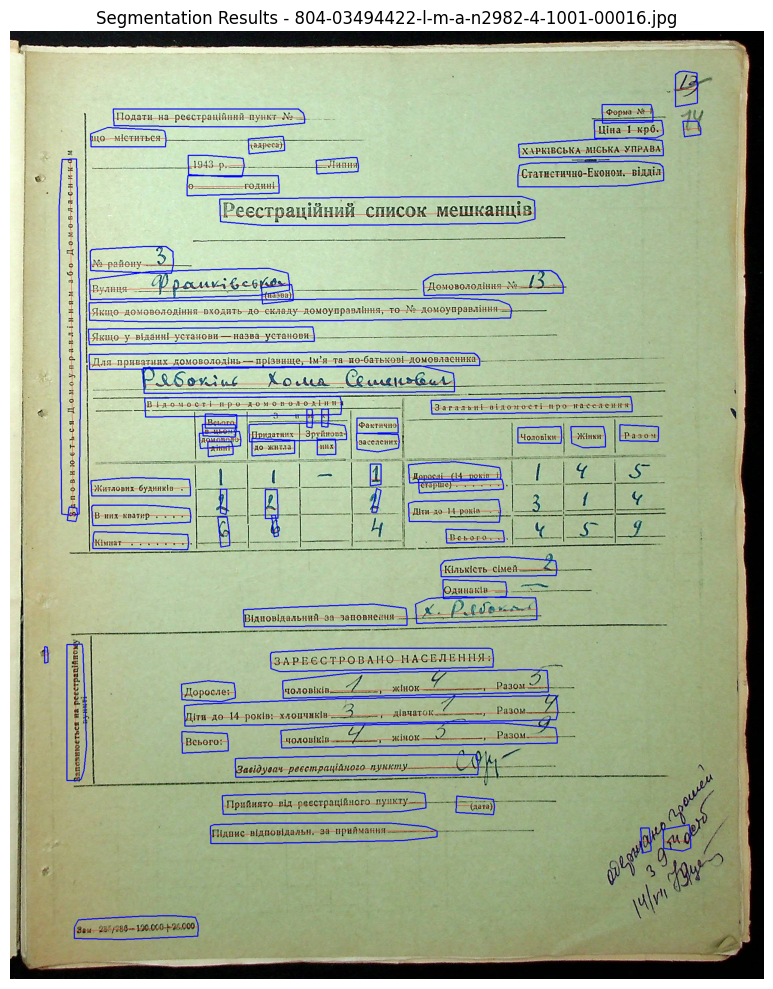

  ℹ️ No person-dense regions extracted


In [10]:
# Display visualizations for successful results
if 'results' in locals() and results:
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    from IPython.display import display, Image as IPImage
    
    # Display visualizations for successful results
    for i, result in enumerate(results[:3]):  # Limit to first 3 images
        if result['success']:
            print(f"\n🎨 Visualizations for Image {i+1}: {os.path.basename(result['image_path'])}")
            
            # Show segmentation visualization if available
            viz_path = result['output_paths'].get('visualization')
            if viz_path and os.path.exists(viz_path):
                try:
                    plt.figure(figsize=(15, 10))
                    img = mpimg.imread(viz_path)
                    plt.imshow(img)
                    plt.title(f"Segmentation Results - {os.path.basename(result['image_path'])}")
                    plt.axis('off')
                    plt.tight_layout()
                    plt.show()
                except Exception as e:
                    print(f"  ⚠️ Could not display segmentation visualization: {e}")
                    
            # Show person region if available
            person_regions_path = result['output_paths'].get('person_regions')
            if person_regions_path and os.path.exists(person_regions_path):
                try:
                    plt.figure(figsize=(12, 8))
                    img = mpimg.imread(person_regions_path)
                    plt.imshow(img)
                    plt.title(f"Person-Dense Region - {os.path.basename(result['image_path'])}")
                    plt.axis('off')
                    plt.tight_layout()
                    plt.show()
                except Exception as e:
                    print(f"  ⚠️ Could not display person region: {e}")
            else:
                print("  ℹ️ No person-dense regions extracted")
else:
    print("⚠️ No results to visualize. Run the processing cell first.")

In [14]:
# Demonstrate NER ALTO enhancement
if 'results' in locals() and results:
    import xml.etree.ElementTree as ET
    from ukrainian_ocr import ALTOEnhancer
    
    for i, result in enumerate(results):
        if result['success']:
            print(f"\n🏷️ NER ALTO Enhancement for Image {i+1}")
            print(f"📄 {os.path.basename(result['image_path'])}")
            
            # Get basic and enhanced ALTO paths
            basic_alto = result['output_paths'].get('alto_basic')
            enhanced_alto = result['output_paths'].get('alto_enhanced')
            
            if basic_alto and enhanced_alto and os.path.exists(enhanced_alto):
                try:
                    # Parse enhanced ALTO to show NER features
                    tree = ET.parse(enhanced_alto)
                    root = tree.getroot()
                    ns = {'alto': 'http://www.loc.gov/standards/alto/ns-v4#'}
                    
                    # Show NER tags
                    ner_tags = []
                    tags_elem = root.find('.//alto:Tags', ns) or root.find('.//Tags')
                    if tags_elem is not None:
                        for tag in tags_elem.findall('.//alto:OtherTag', ns) + tags_elem.findall('.//OtherTag'):
                            tag_id = tag.get('ID', '')
                            description = tag.get('DESCRIPTION', '')
                            if 'NER_' in description:
                                ner_tags.append((tag_id, description))
                    
                    print(f"\n📋 NER Tags Created:")
                    if ner_tags:
                        for tag_id, description in ner_tags:
                            print(f"  {tag_id}: {description}")
                    else:
                        print("  No NER tags found")
                    
                    # Find lines with entities
                    entity_lines = []
                    text_lines = root.findall('.//alto:TextLine', ns) + root.findall('.//TextLine')
                    
                    for line in text_lines:
                        entity_types = line.get('ENTITY_TYPES')
                        entity_texts = line.get('ENTITY_TEXTS')
                        tagrefs = line.get('TAGREFS', '')
                        
                        if entity_types and entity_texts:
                            # Get line text
                            string_elem = line.find('.//alto:String', ns) or line.find('.//String')
                            line_text = string_elem.get('CONTENT', '') if string_elem is not None else ''
                            
                            entity_lines.append({
                                'id': line.get('ID', ''),
                                'text': line_text,
                                'entity_types': entity_types,
                                'entity_texts': entity_texts,
                                'tagrefs': tagrefs
                            })
                    
                    print(f"\n🎯 Lines with Named Entities:")
                    if entity_lines:
                        print(f"  Found {len(entity_lines)} lines with entities")
                        for j, line in enumerate(entity_lines[:5]):  # Show first 5
                            print(f"\\n  Line {j+1}: {line['text']}")
                            print(f"    Entity Types: {line['entity_types']}")
                            print(f"    Entity Texts: {line['entity_texts']}")
                            print(f"    TAGREFS: {line['tagrefs']}")
                            
                        if len(entity_lines) > 5:
                            print(f"    ... and {len(entity_lines) - 5} more lines with entities")
                    else:
                        print("  No entities found in this document")
                    
                    # Compare file sizes
                    basic_size = os.path.getsize(basic_alto) / 1024
                    enhanced_size = os.path.getsize(enhanced_alto) / 1024
                    enhancement_ratio = enhanced_size / basic_size
                    
                    print(f"\\n📊 Enhancement Statistics:")
                    print(f"  Basic ALTO: {basic_size:.1f}KB")
                    print(f"  Enhanced ALTO: {enhanced_size:.1f}KB")
                    print(f"  Enhancement ratio: {enhancement_ratio:.1f}x")
                    
                    # Show XML sample comparison
                    print(f"\\n🔍 XML Structure Comparison:")
                    
                    # Basic ALTO sample
                    basic_tree = ET.parse(basic_alto)
                    basic_root = basic_tree.getroot()
                    basic_line = basic_root.find('.//alto:TextLine', ns) or basic_root.find('.//TextLine')
                    if basic_line is not None:
                        print(f"\\n  Basic ALTO TextLine:")
                        print(f"    ID: {basic_line.get('ID', 'N/A')}")
                        print(f"    TAGREFS: {basic_line.get('TAGREFS', 'N/A')}")
                        print(f"    Attributes: {len(basic_line.attrib)} total")
                    
                    # Enhanced ALTO sample
                    enhanced_line = entity_lines[0] if entity_lines else None
                    if enhanced_line:
                        print(f"\\n  Enhanced ALTO TextLine (with entities):")
                        print(f"    ID: {enhanced_line['id']}")
                        print(f"    TAGREFS: {enhanced_line['tagrefs']}")
                        print(f"    ENTITY_TYPES: {enhanced_line['entity_types']}")
                        print(f"    ENTITY_TEXTS: {enhanced_line['entity_texts']}")
                        print(f"    Additional NER attributes added")
                        
                except Exception as e:
                    print(f"  ⚠️ Error analyzing enhanced ALTO: {e}")
            else:
                print("  ⚠️ Enhanced ALTO not found or not created")
            
            print("-" * 60)
            
    # Show enhancement process
    print(f"\\n🔧 About NER ALTO Enhancement:")
    print("• Analyzes text content for named entities (persons, locations, organizations)")  
    print("• Creates specialized LT (Line Type) tags for entity categories")
    print("• Adds TAGREFS pointing to appropriate entity type tags")
    print("• Includes ENTITY_TYPES and ENTITY_TEXTS attributes on TextLine elements")
    print("• Creates person-dense regions using DBSCAN clustering")
    print("• Maintains full ALTO v4 compliance for archival standards")
    print("\\n💡 Enhanced ALTO files can be imported into:")
    print("• eScriptorium for further manual correction")
    print("• Digital archive systems supporting ALTO v4")
    print("• Custom genealogical research workflows")
    
else:
    print("⚠️ No results available. Run the processing cell first.")


🏷️ NER ALTO Enhancement for Image 1
📄 804-03494422-l-m-a-n2982-4-1001-00016.jpg
  ⚠️ Enhanced ALTO not found or not created
------------------------------------------------------------
\n🔧 About NER ALTO Enhancement:
• Analyzes text content for named entities (persons, locations, organizations)
• Creates specialized LT (Line Type) tags for entity categories
• Adds TAGREFS pointing to appropriate entity type tags
• Includes ENTITY_TYPES and ENTITY_TEXTS attributes on TextLine elements
• Creates person-dense regions using DBSCAN clustering
• Maintains full ALTO v4 compliance for archival standards
\n💡 Enhanced ALTO files can be imported into:
• eScriptorium for further manual correction
• Digital archive systems supporting ALTO v4
• Custom genealogical research workflows


In [15]:
# Manual ALTO Enhancement Demo
# This shows how to enhance a basic ALTO file with NER manually

if 'results' in locals() and results:
    from ukrainian_ocr import ALTOEnhancer, NERExtractor
    import xml.etree.ElementTree as ET
    
    # Take the first successful result
    result = next((r for r in results if r['success']), None)
    
    if result:
        basic_alto_path = result['output_paths'].get('alto_basic')
        
        if basic_alto_path and os.path.exists(basic_alto_path):
            print("🔧 Manual ALTO Enhancement Process")
            print(f"📄 Source: {os.path.basename(basic_alto_path)}")
            
            try:
                # Step 1: Extract text from ALTO file
                print("\n1️⃣ Extracting text from ALTO file...")
                tree = ET.parse(basic_alto_path)
                root = tree.getroot()
                ns = {'alto': 'http://www.loc.gov/standards/alto/ns-v4#'}
                
                # Extract text lines from ALTO
                lines_data = []
                text_lines = root.findall('.//alto:TextLine', ns) + root.findall('.//TextLine')
                
                for line in text_lines:
                    line_id = line.get('ID', '')
                    string_elem = line.find('.//alto:String', ns) or line.find('.//String')
                    if string_elem is not None:
                        text = string_elem.get('CONTENT', '')
                        if text.strip():
                            lines_data.append({
                                'id': line_id,
                                'text': text
                            })
                
                print(f"   Extracted {len(lines_data)} text lines from ALTO")
                
                # Step 2: Extract entities using NERExtractor
                print("\n2️⃣ Extracting named entities...")
                ner_extractor = NERExtractor()
                
                # Process lines for entities
                entities_by_line = {}
                total_entities = 0
                
                for line_data in lines_data:
                    line_id = line_data['id']
                    text = line_data['text']
                    
                    # Extract entities from this line
                    entities = ner_extractor.extract_entities_from_text(text)
                    
                    if entities:
                        entities_by_line[line_id] = {'entities': entities}
                        total_entities += len(entities)
                
                print(f"   Found {total_entities} entities in {len(entities_by_line)} lines")
                
                # Show entity breakdown
                if total_entities > 0:
                    entity_types = {}
                    for line_id, line_data in entities_by_line.items():
                        for entity in line_data['entities']:
                            label = entity.get('label', 'UNKNOWN')
                            if label not in entity_types:
                                entity_types[label] = []
                            entity_types[label].append(entity.get('text', ''))
                    
                    print("\n   Entity breakdown:")
                    for label, texts in entity_types.items():
                        print(f"   {label}: {len(texts)} entities")
                        sample_texts = list(set(texts))[:3]  # Show unique samples
                        print(f"     Examples: {', '.join(sample_texts)}")
                
                # Step 3: Enhance ALTO with NER
                if entities_by_line:
                    print("\n3️⃣ Enhancing ALTO with NER annotations...")
                    enhancer = ALTOEnhancer()
                    
                    # Create enhanced version
                    manual_enhanced_path = basic_alto_path.replace('.xml', '_manual_enhanced.xml')
                    enhanced_path = enhancer.enhance_alto_with_ner(
                        basic_alto_path, 
                        entities_by_line,
                        manual_enhanced_path
                    )
                    
                    if os.path.exists(enhanced_path):
                        enhanced_size = os.path.getsize(enhanced_path) / 1024
                        basic_size = os.path.getsize(basic_alto_path) / 1024
                        print(f"   ✅ Enhanced ALTO created: {os.path.basename(enhanced_path)}")
                        print(f"   Size: {basic_size:.1f}KB → {enhanced_size:.1f}KB")
                        
                        # Step 4: Verify enhancement
                        print("\n4️⃣ Verifying enhancement...")
                        tree = ET.parse(enhanced_path)
                        root = tree.getroot()
                        
                        # Count NER tags
                        tags_elem = root.find('.//alto:Tags', ns) or root.find('.//Tags')
                        ner_tag_count = 0
                        
                        if tags_elem is not None:
                            for tag in tags_elem.findall('.//alto:OtherTag', ns) + tags_elem.findall('.//OtherTag'):
                                description = tag.get('DESCRIPTION', '')
                                if 'NER_' in description:
                                    ner_tag_count += 1
                                    tag_id = tag.get('ID', '')
                                    print(f"     {tag_id}: {description}")
                        
                        # Count enhanced lines
                        enhanced_line_count = 0
                        enhanced_text_lines = root.findall('.//alto:TextLine', ns) + root.findall('.//TextLine')
                        
                        for line in enhanced_text_lines:
                            if line.get('ENTITY_TYPES') or line.get('ENTITY_TEXTS'):
                                enhanced_line_count += 1
                        
                        print(f"\n   Statistics:")
                        print(f"   NER tags created: {ner_tag_count}")
                        print(f"   Lines with entities: {enhanced_line_count}")
                        print(f"   Total lines: {len(enhanced_text_lines)}")
                        print("   ✅ Enhancement completed successfully!")
                        
                    else:
                        print("   ❌ Enhancement failed")
                else:
                    print("\n   ℹ️ No entities found to enhance ALTO with")
                    print("   💡 This may be due to:")
                    print("      • SpaCy not installed (using rule-based extraction)")
                    print("      • Document doesn't contain recognizable names")
                    print("      • Text recognition quality issues")
                    
            except Exception as e:
                print(f"❌ Manual enhancement error: {e}")
                import traceback
                traceback.print_exc()
                
        else:
            print("⚠️ No basic ALTO file found for manual enhancement")
    else:
        print("⚠️ No successful results found for manual enhancement")
        
else:
    print("⚠️ No results available. Run the processing cell first.")

/tmp/ipykernel_2498375/1520530203.py:31: DeprecationWarning: Testing an element's truth value will raise an exception in future versions.  Use specific 'len(elem)' or 'elem is not None' test instead.
  string_elem = line.find('.//alto:String', ns) or line.find('.//String')
spaCy not installed


🔧 Manual ALTO Enhancement Process
📄 Source: 804-03494422-l-m-a-n2982-4-1001-00016.xml

1️⃣ Extracting text from ALTO file...
   Extracted 0 text lines from ALTO

2️⃣ Extracting named entities...
   Found 0 entities in 0 lines

   ℹ️ No entities found to enhance ALTO with
   💡 This may be due to:
      • SpaCy not installed (using rule-based extraction)
      • Document doesn't contain recognizable names
      • Text recognition quality issues


## 🔧 Manual ALTO Enhancement Demo

Demonstrate manual ALTO enhancement using the ALTOEnhancer component.

## 🏷️ NER ALTO Enhancement

Demonstrate the Named Entity Recognition enhancement of ALTO XML files.

## 💾 Export Results

Export your processing results to different formats.

In [11]:
# Export results summary
if 'results' in locals() and results:
    import json
    from datetime import datetime
    
    # Create comprehensive results summary
    summary = {
        'processing_info': {
            'timestamp': datetime.now().isoformat(),
            'total_images': len(results),
            'successful': sum(1 for r in results if r['success']),
            'failed': sum(1 for r in results if not r['success']),
            'total_processing_time': sum(r.get('processing_time', 0) for r in results),
            'system_info': {
                'device_used': config.device,
                'batch_size': config.batch_size,
                'python_version': sys.version.split()[0],
                'pytorch_version': torch.__version__
            }
        },
        'results': results
    }
    
    # Save results summary as JSON
    summary_path = os.path.join(output_dir, 'processing_summary.json')
    with open(summary_path, 'w', encoding='utf-8') as f:
        json.dump(summary, f, indent=2, ensure_ascii=False, default=str)
    
    # Create text summary
    text_summary_path = os.path.join(output_dir, 'processing_summary.txt')
    with open(text_summary_path, 'w', encoding='utf-8') as f:
        f.write("Ukrainian OCR Pipeline - Processing Summary\n")
        f.write("=" * 45 + "\n\n")
        f.write(f"Timestamp: {summary['processing_info']['timestamp']}\n")
        f.write(f"Total Images: {summary['processing_info']['total_images']}\n")
        f.write(f"Successful: {summary['processing_info']['successful']}\n")
        f.write(f"Failed: {summary['processing_info']['failed']}\n")
        f.write(f"Total Time: {summary['processing_info']['total_processing_time']:.2f}s\n")
        f.write(f"Device Used: {summary['processing_info']['system_info']['device_used']}\n\n")
        
        # Add details for each image
        for i, result in enumerate(results):
            f.write(f"Image {i+1}: {os.path.basename(result['image_path'])}\n")
            if result['success']:
                f.write(f"  Status: Success\n")
                f.write(f"  Processing Time: {result['processing_time']:.2f}s\n")
                f.write(f"  Lines Detected: {result['lines_detected']}\n")
                f.write(f"  Lines with Text: {result['lines_with_text']}\n")
                if 'entities_extracted' in result:
                    f.write(f"  Entities Extracted: {result.get('total_entities', 0)}\n")
            else:
                f.write(f"  Status: Failed\n")
                f.write(f"  Error: {result.get('error', 'Unknown error')}\n")
            f.write("\n")
    
    print(f"📄 Results exported:")
    print(f"  JSON summary: {summary_path}")
    print(f"  Text summary: {text_summary_path}")
    
    # Show output directory contents
    print(f"\n📁 Output directory ({output_dir}):")
    for root, dirs, files in os.walk(output_dir):
        level = root.replace(output_dir, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 2 * (level + 1)
        for file in files:
            file_path = os.path.join(root, file)
            size_kb = os.path.getsize(file_path) / 1024
            print(f"{subindent}{file} ({size_kb:.1f}KB)")
    
else:
    print("⚠️ No results to export. Run the processing cell first.")

📄 Results exported:
  JSON summary: ./test_results/processing_summary.json
  Text summary: ./test_results/processing_summary.txt

📁 Output directory (./test_results):
test_results/
  804-03494422-l-m-a-n2982-4-1001-00016.xml (28.9KB)
  804-03494422-l-m-a-n2982-4-1001-00016_segmentation.png (6823.8KB)
  804-03494422-l-m-a-n2982-4-1001-00076.xml (27.8KB)
  804-03494422-l-m-a-n2982-4-1001-00045_enhanced.xml (110.1KB)
  804-03494422-l-m-a-n2982-4-1001-00045_segmentation.png (13011.7KB)
  processing_summary.json (0.9KB)
  804-03494422-l-m-a-n2982-4-1001-00045.xml (66.4KB)
  804-03494422-l-m-a-n2982-4-1001-00076_segmentation.png (6724.1KB)
  804-03494422-l-m-a-n2982-4-1001-00016_enhanced.xml (49.4KB)
  processing_summary.txt (0.4KB)
  804-03494422-l-m-a-n2982-4-1001-00076_enhanced.xml (49.0KB)


## 🧹 Cleanup

Clean up GPU memory and temporary resources.

In [ ]:
# Clean up pipeline resources
if 'pipeline' in locals():
    pipeline.cleanup()
    print("✅ Pipeline resources cleaned up")

# Show final memory usage
if torch.cuda.is_available():
    print(f"\n📊 Final GPU Memory Usage:")
    allocated = torch.cuda.memory_allocated() / 1024**3
    cached = torch.cuda.memory_reserved() / 1024**3
    print(f"  Allocated: {allocated:.2f}GB")
    print(f"  Cached: {cached:.2f}GB")
    
    # Force cleanup
    torch.cuda.empty_cache()
    print("  ✅ GPU cache cleared")

print("\n🎉 Local testing complete!")
if 'output_dir' in locals():
    print(f"📚 Check the results in: {os.path.abspath(output_dir)}")

## 🔧 Development & Testing Utilities

Additional utilities for development and testing.

In [ ]:
# Quick model testing function
def test_individual_components():
    """Test individual pipeline components"""
    print("🔧 Testing individual components...\n")
    
    # Test segmentation
    try:
        from ukrainian_ocr.core.segmentation import KrakenSegmenter
        import cv2
        
        if image_files:
            test_img = cv2.imread(image_files[0])
            segmenter = KrakenSegmenter(device='cpu')  # Use CPU for testing
            lines = segmenter.segment_image(test_img)
            print(f"✅ Segmentation: {len(lines)} lines detected")
        else:
            print("⚠️ Segmentation: No test images available")
    except Exception as e:
        print(f"❌ Segmentation error: {e}")
    
    # Test OCR
    try:
        from ukrainian_ocr.core.ocr import TrOCRProcessor
        import numpy as np
        
        ocr_processor = TrOCRProcessor(device='cpu')  # Use CPU for testing
        
        # Create a small test image
        test_image = np.ones((50, 200, 3), dtype=np.uint8) * 255
        result = ocr_processor.recognize_text(test_image)
        print(f"✅ OCR: Model loaded, test returned: '{result['text']}'")
    except Exception as e:
        print(f"❌ OCR error: {e}")
    
    # Test NER
    try:
        from ukrainian_ocr.core.ner import NERExtractor
        
        ner_extractor = NERExtractor()
        entities = ner_extractor.extract_entities("Иван Петров из Киева")
        print(f"✅ NER: {len(entities)} entities found in test text")
    except Exception as e:
        print(f"❌ NER error: {e}")

# Uncomment to test individual components
# test_individual_components()

In [ ]:
# Performance benchmarking
def benchmark_pipeline():
    """Benchmark pipeline performance on different settings"""
    print("📊 Benchmarking pipeline performance...\n")
    
    if not image_files:
        print("⚠️ No test images available for benchmarking")
        return
    
    test_image = image_files[0]
    
    # Test different configurations
    configs_to_test = [
        {'device': 'cpu', 'batch_size': 1, 'name': 'CPU Single'},
    ]
    
    if torch.cuda.is_available():
        configs_to_test.extend([
            {'device': 'cuda', 'batch_size': 1, 'name': 'GPU Single'},
            {'device': 'cuda', 'batch_size': 4, 'name': 'GPU Batch'},
        ])
    
    for test_config in configs_to_test:
        try:
            print(f"Testing {test_config['name']}...")
            
            # Create test pipeline
            test_pipeline = UkrainianOCRPipeline(
                device=test_config['device'],
                batch_size=test_config['batch_size'],
                verbose=False
            )
            
            # Time the processing
            import time
            start = time.time()
            result = test_pipeline.process_single_image(
                test_image,
                output_dir='./benchmark_temp',
                save_intermediate=False
            )
            end = time.time()
            
            if result['success']:
                print(f"  ✅ {test_config['name']}: {end-start:.2f}s")
            else:
                print(f"  ❌ {test_config['name']}: Failed")
            
            # Cleanup
            test_pipeline.cleanup()
            
        except Exception as e:
            print(f"  ❌ {test_config['name']}: Error - {e}")
    
    # Cleanup benchmark temp directory
    import shutil
    if os.path.exists('./benchmark_temp'):
        shutil.rmtree('./benchmark_temp')

# Uncomment to run benchmark
# benchmark_pipeline()

## 🚀 Next Steps

**What you can do with the results:**

1. **ALTO XML files** - Import into eScriptorium or other document analysis tools
2. **Enhanced ALTO** - Contains named entity annotations for persons and locations
3. **Person-dense regions** - Cropped images focusing on genealogically valuable content
4. **Entity extraction** - Use the identified persons and locations for genealogical research

**For production use:**
- Use the CLI interface: `ukrainian-ocr --help`
- Customize configuration files
- Integrate with existing workflows
- Process larger batches of documents

**Development:**
- Modify component implementations in `ukrainian_ocr/core/`
- Add custom NER models
- Extend ALTO XML generation
- Add new post-processing features

**Need help?**
- Check the package documentation
- Review the configuration options
- Test individual components using the utilities above
